In [1]:
import pandas as pd
import numpy as np

# Import and Transform Data

In [2]:
# Read CSV data and verify
sparse_covid_df = pd.read_csv('../data/covid/sparse_county_covid.csv',index_col=0)
dense_covid_df = pd.read_csv('../data/covid/dense_county_covid.csv',index_col=0)
weather_df = pd.read_csv('../data/weather/county_weather.csv',index_col=0)

In [3]:
# Add population density and total population values
density = {
    'baltimore': 6866,
    'essex': 6168,
    'cook': 5301,
    'union': 5150,
    'norfolk': 5026,
    'nassau': 4954,
    'harrisonburg':4765,
    'fairfax':2454,
    'camden':2289,
    'harris':2700,
    'franklin':2186,
    'marion':2466,
    'dekalb':2482,
    'duval':1305,
    'wake':1377,
    'bexar':1620
}

population = {
    'baltimore': 621342,
    'essex': 755618,
    'cook': 5231351,
    'union': 543976,
    'norfolk': 245782,
    'nassau': 74629,
    'harrisonburg':50981,
    'fairfax':1118602,
    'camden':513539,
    'harris':4253700,
    'franklin':1195537,
    'marion':918977,
    'dekalb':707089,
    'duval':879602,
    'wake':952151,
    'bexar':1785704
}

In [4]:
# Add pop_density and population columns to covid data
sparse_covid_df['population'] = pd.Series(dtype=int)
sparse_covid_df['pop_density'] = pd.Series(dtype=int)

dense_covid_df['population'] = pd.Series(dtype=int)
dense_covid_df['pop_density'] = pd.Series(dtype=int)

# Set population and density columns for sparse counties
for i in range(len(sparse_covid_df.index)):
    county = sparse_covid_df.iloc[i,1]

    sparse_covid_df.iloc[i,7] = population[county]
    sparse_covid_df.iloc[i,8] = density[county]

# Set population and density columns for dense counties
for i in range(len(dense_covid_df.index)):
    county = dense_covid_df.iloc[i,1]

    dense_covid_df.iloc[i,7] = population[county]
    dense_covid_df.iloc[i,8] = density[county]

In [5]:
# Add past_delta14 columns to sparse and dense counties
sparse_covid_df['past_delta14'] = pd.Series(dtype=int)
dense_covid_df['past_delta14'] = pd.Series(dtype=int)

# Sparse county past_delta_14
for i in range(14,len(sparse_covid_df.index)):

    # Set past_delta_14
    past_cases = sparse_covid_df.iloc[i-14,3]
    present_cases = sparse_covid_df.iloc[i,3]
    delta14 = present_cases - past_cases

    sparse_covid_df.iloc[i,9] = delta14

# Dense county past delta14
for i in range(14,len(dense_covid_df.index)):

    # Set past_delta_14
    past_cases = dense_covid_df.iloc[i-14,3]
    present_cases = dense_covid_df.iloc[i,3]
    delta14 = present_cases - past_cases

    dense_covid_df.iloc[i,9] = delta14

In [6]:
# Sort weather data according to the sparse or dense county sets
sparse_counties = sparse_covid_df['county'].unique()
dense_counties = dense_covid_df['county'].unique()

# Sort weather for each set
sparse_weather_df = weather_df[weather_df['county'].isin(sparse_counties)]
dense_weather_df = weather_df[weather_df['county'].isin(dense_counties)]

In [7]:
# Merge weather data on sparse and dense covid data
sparse_weather_covid_df = sparse_covid_df.merge(sparse_weather_df,on=['date','county'])
dense_weather_covid_df = dense_covid_df.merge(dense_weather_df,on=['date','county'])

In [8]:
# Verify Sparse Data
sparse_weather_covid_df.head()

,date,county,state_x,total_cases,new_cases,future_delta7,future_delta14,population,pop_density,past_delta14,state_y,temp_mean(C),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
0,2020-03-07,fairfax,virginia,1,1,9.0,21.0,1118602.0,2454.0,NaN,virginia,5.0,0.0,27.6,30,65,48.0
1,2020-03-08,fairfax,virginia,2,1,8.0,29.0,1118602.0,2454.0,NaN,virginia,6.8,0.0,16.7,24,67,47.0
2,2020-03-09,fairfax,virginia,4,2,6.0,39.0,1118602.0,2454.0,NaN,virginia,11.7,0.0,18.8,30,69,50.0
3,2020-03-10,fairfax,virginia,4,0,8.0,42.0,1118602.0,2454.0,NaN,virginia,14.6,2.1,29.8,49,95,69.0
4,2020-03-11,fairfax,virginia,4,0,10.0,72.0,1118602.0,2454.0,NaN,virginia,9.1,0.6,15.7,63,91,73.0


In [9]:
# Verify Dense Data
dense_weather_covid_df.head()

,date,county,state_x,total_cases,new_cases,future_delta7,future_delta14,population,pop_density,past_delta14,state_y,temp_mean(C),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
0,2020-03-11,baltimore,maryland,1,1,6.0,50.0,621342.0,6866.0,NaN,maryland,9.1,0.2,20.9,54,88,72.0
1,2020-03-12,baltimore,maryland,1,0,12.0,80.0,621342.0,6866.0,NaN,maryland,9.9,0.0,14.8,57,93,77.0
2,2020-03-13,baltimore,maryland,2,1,11.0,101.0,621342.0,6866.0,NaN,maryland,14.5,7.6,24.7,34,98,69.0
3,2020-03-14,baltimore,maryland,3,1,16.0,138.0,621342.0,6866.0,NaN,maryland,9.4,2.0,20.1,32,81,45.0
4,2020-03-15,baltimore,maryland,3,0,25.0,159.0,621342.0,6866.0,NaN,maryland,7.1,6.9,14.7,46,92,75.0


In [10]:
# Set Feature categories
weather_features = ['temp_mean(C)','precip_sum(mm)','wind_max(km/h)','min_humidity(%)','max_humidity(%)','mean_humidity(%)']
county_features = ['population','pop_density']
covid_features = ['new_cases','past_delta14']
target = ['future_delta14']

In [11]:
# Reorder and drop unnecessary columns
sparse_weather_covid_df = sparse_weather_covid_df[target + county_features + covid_features + weather_features]
dense_weather_covid_df = dense_weather_covid_df[target + county_features + covid_features + weather_features]

# Analyze Data

## Sparse County Data

In [12]:
# Sparse Data Summary Statistics
sparse_weather_covid_df.describe()

,future_delta14,population,pop_density,new_cases,past_delta14,temp_mean(C),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
count,2358.000000,2.484000e+03,2484.000000,2484.000000,2470.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000,2484.000000
mean,3074.367684,1.376589e+06,2093.638486,222.941224,450.959514,19.917069,3.416304,16.427295,51.813607,89.427939,71.770531
std,4100.141668,1.073684e+06,493.989603,442.387108,16860.068051,7.050057,7.817141,5.773005,14.826133,10.193894,12.781493
min,0.000000,5.135390e+05,1305.000000,-95.000000,-196506.000000,-1.600000,0.000000,5.800000,10.000000,36.000000,24.000000
25%,763.750000,8.796020e+05,1620.000000,41.000000,650.000000,14.800000,0.000000,12.200000,41.000000,85.000000,63.000000
50%,1771.000000,9.521510e+05,2289.000000,111.000000,1687.500000,21.500000,0.200000,15.500000,51.000000,93.000000,73.000000
75%,2996.250000,1.195537e+06,2466.000000,217.250000,2907.750000,25.500000,3.100000,19.825000,62.000000,97.000000,81.000000
max,26434.000000,4.253700e+06,2700.000000,14129.000000,26434.000000,33.000000,98.300000,49.700000,97.000000,100.000000,99.000000


In [13]:
sparse_weather_covid_df.corr()

,future_delta14,population,pop_density,new_cases,past_delta14,temp_mean(C),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
future_delta14,1.000000,0.635549,0.204798,0.582395,0.286672,0.216100,-0.026774,0.024872,0.011728,0.023492,0.021529
population,0.635549,1.000000,0.318813,0.410475,0.172732,0.240532,-0.022786,0.083723,0.014291,0.073293,0.051782
pop_density,0.204798,0.318813,1.000000,0.131063,0.043526,-0.174792,-0.000608,0.066393,-0.020296,-0.036833,-0.036251
new_cases,0.582395,0.410475,0.131063,1.000000,0.233212,0.079365,0.026610,0.058811,0.038414,0.021690,0.035544
past_delta14,0.286672,0.172732,0.043526,0.233212,1.000000,0.230270,-0.008490,-0.025873,-0.047613,-0.016669,-0.033137
temp_mean(C),0.216100,0.240532,-0.174792,0.079365,0.230270,1.000000,-0.009219,-0.244493,0.030811,0.282434,0.168608
precip_sum(mm),-0.026774,-0.022786,-0.000608,0.026610,-0.008490,-0.009219,1.000000,0.199469,0.444224,0.310526,0.443770
wind_max(km/h),0.024872,0.083723,0.066393,0.058811,-0.025873,-0.244493,0.199469,1.000000,-0.057825,-0.156923,-0.127772
min_humidity(%),0.011728,0.014291,-0.020296,0.038414,-0.047613,0.030811,0.444224,-0.057825,1.000000,0.570951,0.900010
max_humidity(%),0.023492,0.073293,-0.036833,0.021690,-0.016669,0.282434,0.310526,-0.156923,0.570951,1.000000,0.821364


array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='population', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='pop_density', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='population'>,
        <AxesSubplot: xlabel='population', ylabel='population'>,
        <AxesSubplot: xlabel='pop_density', ylabel='population'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='pop_density'>,
        <AxesSubplot: xlabel='population', ylabel='pop_density'>,
        <AxesSubplot: xlabel='pop_density', ylabel='pop_density'>]],
      dtype=object)

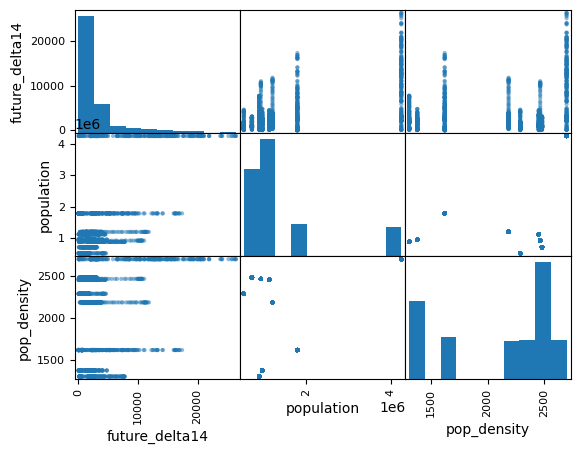

In [14]:
# Scatter plot for target with county features
pd.plotting.scatter_matrix(sparse_weather_covid_df[target + county_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='new_cases'>,
        <AxesSubplot: xlabel='new_cases', ylabel='new_cases'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='new_cases'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='past_delta14'>]],
      dtype=object)

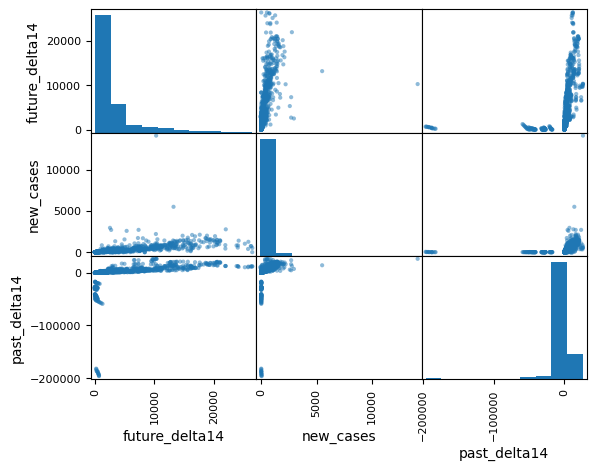

In [15]:
# Scatter plot for target with covid features
pd.plotting.scatter_matrix(sparse_weather_covid_df[target + covid_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='temp_mean(C)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='temp_mean(C)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='tem

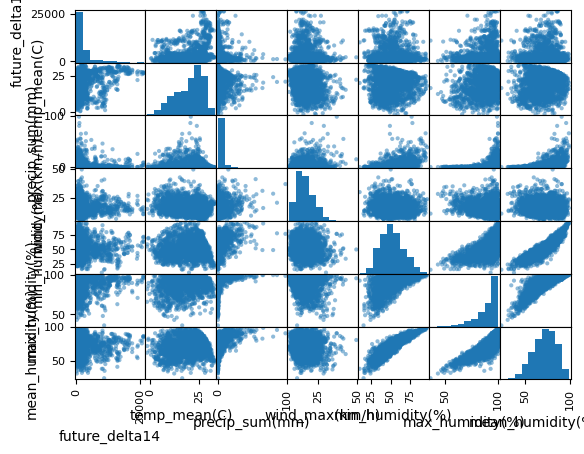

In [16]:
# Scatter plot for target with weather features
pd.plotting.scatter_matrix(sparse_weather_covid_df[target + weather_features])

## Dense County Data

In [17]:
dense_weather_covid_df.describe()

,future_delta14,population,pop_density,new_cases,past_delta14,temp_mean(C),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
count,1835.000000,1.933000e+03,1933.000000,1933.000000,1919.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000
mean,3549.147684,1.177306e+06,5458.012933,258.456803,25.097447,16.340352,3.509364,18.371909,55.582514,89.015520,73.369374
std,8010.570199,1.813286e+06,701.967411,621.619469,28149.981897,7.576094,7.793745,7.265462,15.127616,10.187973,12.166935
min,-174.000000,5.098100e+04,4765.000000,-168.000000,-325689.000000,-13.000000,0.000000,5.400000,23.000000,46.000000,35.000000
25%,257.000000,7.462900e+04,4954.000000,14.000000,221.000000,10.100000,0.000000,13.000000,44.000000,84.000000,65.000000
50%,898.000000,5.439760e+05,5150.000000,55.000000,782.000000,16.800000,0.100000,16.900000,55.000000,92.000000,74.000000
75%,3246.000000,7.556180e+05,6168.000000,223.000000,2814.500000,23.000000,3.200000,22.400000,66.000000,97.000000,83.000000
max,63307.000000,5.231351e+06,6866.000000,6697.000000,63307.000000,31.500000,72.800000,68.400000,95.000000,100.000000,99.000000


In [18]:
dense_weather_covid_df.corr()

,future_delta14,population,pop_density,new_cases,past_delta14,temp_mean(C),precip_sum(mm),wind_max(km/h),min_humidity(%),max_humidity(%),mean_humidity(%)
future_delta14,1.000000,0.576992,-0.035288,0.916685,0.248185,-0.267857,-0.013184,0.253232,0.047639,-0.190143,-0.071588
population,0.576992,1.000000,0.010980,0.545186,0.180392,-0.231027,-0.031198,0.151988,0.145833,-0.141640,-0.005510
pop_density,-0.035288,0.010980,1.000000,-0.032605,0.040886,0.041461,0.023248,0.034437,-0.039777,-0.011022,-0.036656
new_cases,0.916685,0.545186,-0.032605,1.000000,0.310545,-0.259490,-0.018679,0.227655,0.050594,-0.187930,-0.066960
past_delta14,0.248185,0.180392,0.040886,0.310545,1.000000,0.059992,0.007009,0.072957,0.041671,-0.011643,0.019237
temp_mean(C),-0.267857,-0.231027,0.041461,-0.259490,0.059992,1.000000,0.023041,-0.311868,0.066298,0.296350,0.210190
precip_sum(mm),-0.013184,-0.031198,0.023248,-0.018679,0.007009,0.023041,1.000000,0.280744,0.412218,0.309898,0.431093
wind_max(km/h),0.253232,0.151988,0.034437,0.227655,0.072957,-0.311868,0.280744,1.000000,-0.022689,-0.304393,-0.198185
min_humidity(%),0.047639,0.145833,-0.039777,0.050594,0.041671,0.066298,0.412218,-0.022689,1.000000,0.506891,0.876429
max_humidity(%),-0.190143,-0.141640,-0.011022,-0.187930,-0.011643,0.296350,0.309898,-0.304393,0.506891,1.000000,0.809591


array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='population', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='pop_density', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='population'>,
        <AxesSubplot: xlabel='population', ylabel='population'>,
        <AxesSubplot: xlabel='pop_density', ylabel='population'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='pop_density'>,
        <AxesSubplot: xlabel='population', ylabel='pop_density'>,
        <AxesSubplot: xlabel='pop_density', ylabel='pop_density'>]],
      dtype=object)

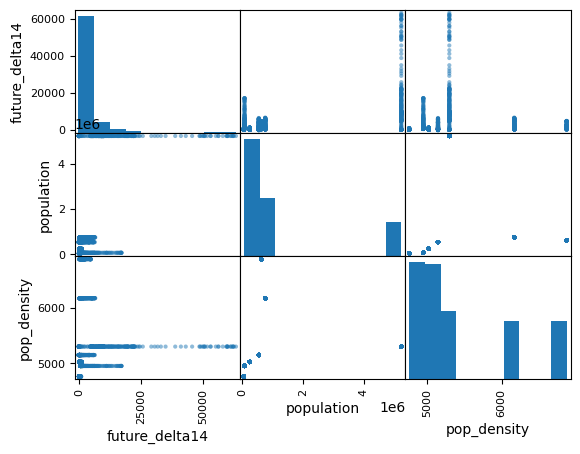

In [19]:
# Scatter plot for target with county features
pd.plotting.scatter_matrix(dense_weather_covid_df[target + county_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='new_cases'>,
        <AxesSubplot: xlabel='new_cases', ylabel='new_cases'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='new_cases'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='new_cases', ylabel='past_delta14'>,
        <AxesSubplot: xlabel='past_delta14', ylabel='past_delta14'>]],
      dtype=object)

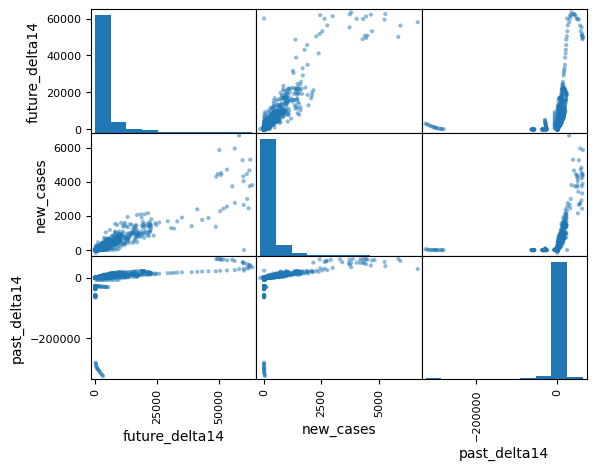

In [20]:
# Scatter plot for target with covid features
pd.plotting.scatter_matrix(dense_weather_covid_df[target + covid_features])

array([[<AxesSubplot: xlabel='future_delta14', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='temp_mean(C)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='future_delta14'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='future_delta14'>],
       [<AxesSubplot: xlabel='future_delta14', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='temp_mean(C)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='precip_sum(mm)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='wind_max(km/h)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='min_humidity(%)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='max_humidity(%)', ylabel='temp_mean(C)'>,
        <AxesSubplot: xlabel='mean_humidity(%)', ylabel='tem

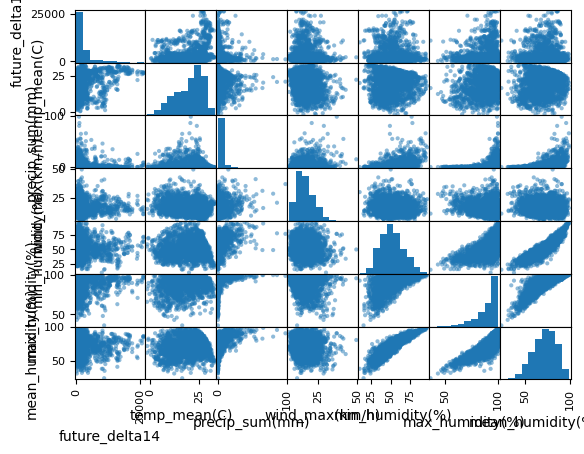

In [21]:
# Scatter plot for target with weather features
pd.plotting.scatter_matrix(sparse_weather_covid_df[target + weather_features])